# Initialization

In [3]:
%matplotlib nbagg
USE_MP = False
import silq
silq.initialize("EWJN")

# qc.show_subprocess_widget()

Initializing imports


C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\matplotlib\__init__.py:1398: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Initializing functions
Initializing instruments
Connected to: Agilent Technologies E8267D (serial:SG53400039, firmware:C.06.22) in 0.04s
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initializing slack
Initialization complete


## ramp voltages

In [ ]:
gates = ['TG', 'LB', 'RB', 'TGAC', 'SRC', 'DS', 'DF']
{param: data.parameter_info(param)[param] for param in gates}

In [6]:

vals = {'DF': 0.47375,
 'DS': 0.47382,
 'LB': 0.98,
 'RB': 0.98,
 'SRC': 0.275,
 'TG': 2.06,
 'TGAC': 0.4222}

ramp_to_voltages(vals)

slack = Slack()

slack.commands['df_ds'] = DF_DS
slack.commands['tgac'] = TGAC
slack.commands['run'] = run_code
slack.commands['halt'] = qc.halt_bg

In [27]:
dark_counts_plunge_parameter = acquisition_parameters.T1Parameter(mode='ESR')

dark_counts_plunge_parameter.pulse_sequence['adiabatic'].enabled = False
dark_counts_plunge_parameter.pulse_sequence['steered_initialization'].enabled = True
dark_counts_plunge_parameter.pulse_sequence['steered_initialization'].mode = 'long'
dark_counts_plunge_parameter.pulse_sequence['plunge'].duration = 20
dark_counts_plunge_parameter.pulse_sequence

PulseSequence with 5 pulses, duration: 42
	SteeredInitialization(steered_initialization (long), t_no_blip=200 ms, t_max_wait=1000, t_buffer=30, V_th=0.3333333333333333)
	DCPulse(plunge, A=0.08, t_start=0, t_stop=20)
	DCPulse(read, A=0, t_start=20, t_stop=40)
	DCPulse(final, A=0, t_start=40, t_stop=42)
	
	Disabled pulses:
	FrequencyRampPulse(adiabatic (ESR), f_center=27951.00 MHz, f_dev=0.50, power=0, t_start=3, t_stop=3.2)

## Register code run commands

In [1]:
%%label adiabatic
samples = 100
points = 7
steps = 10

y_sweep, x_sweep = create_set_vals(2, step_percentage=steps, points=points)
adiabatic_ESR_parameter.samples = samples
data = qc.Loop(
    y_sweep).loop(
        x_sweep).each(
            adiabatic_ESR_parameter).run(
    name='adiabatic_calibration', progress_interval=True)
CalibrationPlot(data)

ERROR:root:Cell magic `%%label` not found.


In [2]:
%%label dc
points = 30
steps = 25

y_sweep, x_sweep = create_set_vals(2, step_percentages=steps, points=points)
DC_parameter.setup()
data = qc.Loop(
    y_sweep).loop(
    x_sweep).each(
    DC_parameter).then(
    qc.Task(layout.stop)).run(
    name='DC_{}_vs_{}_scan'.format(y_sweep.name, x_sweep.name),
    progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

ERROR:root:Cell magic `%%label` not found.


## Threshold voltage

In [176]:
EPR_parameter.single_settings(samples=50)
EPR_parameter.setup()
voltage_difference = EPR_parameter()[-1]

assert voltage_difference, "Couldn't find accurate threshold"
readout_threshold_voltage = voltage_difference / 2

print('Threshold voltage found at {:.2f} V'.format(readout_threshold_voltage))
properties_config['readout_threshold_voltage'] = readout_threshold_voltage

Threshold voltage found at 0.49 V


## ESR frequency

In [ ]:
select_ESR_parameter.single_settings(samples=30, silent=False)
select_ESR_parameter();

# DC Measurements

## DC - Turnon
Here several gates are combined to the parameter turnon_param.

In [ ]:
turnon_vals = turnon_parameter[list(np.linspace(1, 1.6, 100))]

In [ ]:
DC_parameter.setup()
data = qc.Loop(turnon_vals
# data = qc.Loop(dummy_parameter[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - Pinchoff
This code pinches off one gate, while keeping the other gates fixed

In [ ]:
turnon_voltage = 1.6
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 100))
gate = TG

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

In [ ]:
turnon_voltage = 1.3
pinchoff_vals = list(np.linspace(turnon_voltage, 0.7, 40))
gatex=LB
gatey=RB

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gatey[pinchoff_vals]
               ).loop(gatex[pinchoff_vals]
                      ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='2D_Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)


## DC - 1D scan
This script performs a 1D DC scan

In [ ]:
gate = DF_DS[list(np.linspace(0.28,0.6, 50))]

DC_parameter.setup()
data = qc.Loop(gate
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

In [33]:
DS()

0.4725

## DC - 2D scan (works)

This measurement performs a 2D DC scan

In [4]:
TGAC(0.3382)
DF_DS(0.5035)

In [5]:
y_sweep, x_sweep = create_set_vals(2, step_percentage=25, points=20)
DC_parameter.setup()

In [6]:
#y_sweep = TGAC[list(np.arange(0.05, 0.55, 0.0025))]
#x_sweep = DF[list(np.arange(0.2,0.61,0.0025))]

loop = Loop(
    y_sweep).loop(
        x_sweep).each(
            DC_parameter).then(
                qc.Task(layout.stop))
data = loop.get_data_set(name='DC_{}_vs_{}_scan'.format(y_sweep.name, x_sweep.name))
plot = qc.MatPlot(data.DC_voltage)
_ = loop.with_bg_task(plot.update).run()

layout.stop()

<IPython.core.display.Javascript object>

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-09/#007_DC_TGAC_vs_DF_DS_scan_12-16-13'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (20,)
   Setpoint | DF_DS_set  | DF_DS        | (20, 20)
   Measured | DC_voltage | DC_voltage   | (20, 20)
started at 2017-04-09 12:16:17


TypeError: zip argument #1 must support iteration

## DC - 2D scan with arbstudio (doesnt work yet)

In [11]:
#ATTENTION: this is still additional voltage on the sim voltages!!!
#arbstudio are divided by 25(?)/20(?)
df_voltages = list(np.linspace(-0.23, 0.23, 150))
tgac_voltages = list(np.linspace(-0.23, 0.23, 150))
df_duration = 20

DC_pulse_sweep_parameter = acquisition_parameters.DCPulseSweepParameter(sweep_name='DF')
DC_pulse_sweep_parameter.pulse_settings = {'duration': df_duration, 
                                           'connection_requirements': {'input_arg': 'chip.DF'}}
DC_pulse_sweep_parameter.additional_pulses = [DCPulse(name='TGAC', amplitude=0, t_start=0, duration=len(df_voltages)*df_duration+2, 
                                                      connection_requirements={'input_arg': 'chip.TGAC'})]

DC_pulse_sweep_parameter.sweep_voltages = df_voltages

tgac_step_parameter = general_parameters.AttributeParameter(DC_pulse_sweep_parameter.pulse_sequence['TGAC'], 'amplitude')

ValueError: setpoint_names must be a tuple of tuples of strings

### 2D scan

In [288]:
loop = Loop(
    tgac_step_parameter[tgac_voltages]).each(
        DC_pulse_sweep_parameter).then(
        qc.Task(layout.stop))
data = loop.get_data_set(name='DC_2D_arb_sweep')
plot =  qc.MatPlot(data.DC_voltage)
_ = loop.with_bg_task(plot.update).run()

layout.stop()

DataSet:
data = qc.load_data('2017-01-31/#007_DC_2D_arb_sweep_14-23-12')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Setpoint | amplitude_set | amplitude    | (150,)
   Measured | DC_voltage    | DC_voltage   | (150, 150)
started at 2017-01-31 14:23:16


### 4D scan (sweep simrack TGAC and DF)

In [7]:
data = qc.Loop(
    TGAC[0.2:0.71:0.1]).loop(
    DF[0.2:0.71:0.1]).loop(
    tgac_step_parameter[tgac_voltages]).each(
        DC_pulse_sweep_parameter).run(
        #qc.Task(partial(print_attr, DC_pulse_sweep_parameter, 'pulse_sequence'))).run(
    name='DC_2D_arb_sweep')

DataSet:
data = qc.load_data('2017-01-18/#002_DC_2D_arb_sweep_13-39-57')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Setpoint | TGAC_set      | TGAC         | (6,)
   Setpoint | DF_set        | DF           | (6, 6)
   Setpoint | amplitude_set | amplitude    | (6, 6, 100)
   Measured | DC_voltage    | DC_voltage   | (6, 6, 100, 100)
started at 2017-01-18 13:40:04


In [4]:
dummy_parameter = ManualParameter(name='dummy')
dummy_parameters = ManualParameter(name='dummy2')

qc.Loop(dummy_parameter[0:10:1]).loop(
    dummy_parameters[0:10:1]).each(dummy_parameter).run(name='test', background=False)

is parameter array
here
also here
DataSet:
data = qc.load_data('2017-01-17/#004_test_11-32-41')
   mode = DataMode.LOCAL
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | dummy_set  | dummy        | (10,)
   Setpoint | dummy2_set | dummy2       | (10, 10)
   Measured | dummy      | dummy        | (10, 10)
started at 2017-01-17 11:32:43


DataSet:
data = qc.load_data('2017-01-17/#004_test_11-32-41')
   mode = DataMode.LOCAL
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | dummy_set  | dummy        | (10,)
   Setpoint | dummy2_set | dummy2       | (10, 10)
   Measured | dummy      | dummy        | (10, 10)

## Tracking a peak

In [4]:
y_sweep = create_set_vals(step_percentage=30, min_val=TGAC(), max_val=0.5, set_parameter=TGAC)

In [82]:
y_sweep = TG[2.05:2.06:0.001]

In [83]:
from silq.parameters.measurement_parameters import TrackPeakParameter
track_peak_parameter = TrackPeakParameter('track_peak', set_parameter=DF_DS, 
                                          acquisition_parameter=DC_parameter, 
                                          step_percentage=20, peak_width=0.015)

In [84]:
DC_parameter.setup()
data = qc.Loop(
    y_sweep).each(
        track_peak_parameter).then(
                qc.Task(layout.stop)).run(
    name='track_peak', progress_interval=True)

DataSet:
data = qc.load_data('2017-01-05/#003_track_peak_12-20-12')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>       | <array.name>     | <array.shape>
   Setpoint | TG_set           | TG               | (10,)
   Measured | index0           | index0           | (10, 14)
   Measured | optimal_set_vals | optimal_set_vals | (10,)
   Measured | DF_DS_set        | DF_DS_set        | (10, 14)
   Measured | DC_voltage       | DC_voltage       | (10, 14)
started at 2017-01-05 12:20:16


In [85]:
data.sync()
plot = qc.MatPlot(subplots=2)
plot[0].add(data.DC_voltage)
plot[1].add(data.optimal_set_vals)

In [ ]:
data.parameter_info[]

In [7]:
DC_parameter.setup()
track_peak_parameter()
layout.stop()
plt.figure()
plt.plot(track_peak_parameter.result[1], track_peak_parameter.result[2])

# EPR measurements (no steering/ESR) (works)

This is a calibration routine to find a point with high contrast (difference in signal between up state and down state). 
This measurement consists of three stages: empty, load, and read.
In the empty stage, the donor atom is ionized. 
It is then loaded with an electron in a random state.
Finally the state is read out for a long duration.
The contrast is found by looking if blips occured at the beginning of the read trace and at the end of the read trace.
The contrast is the difference in percentage of blips occuring at the beginning versus at the end.
The end part of the read trace is related to the number of dark counts, since we assume that an up-state electron will have had enough time to have tunneled off and on again.

## EPR - 2D scan

In [35]:
#TGAC(0.3382) #factor 5
#DF_DS(0.5035) #factor 4 to matlab
y_sweep, x_sweep = create_set_vals(2, step_percentage=20, points=8)
#y_sweep, x_sweep = create_set_vals('2D', spans=0, nums=5)

<IPython.core.display.Javascript object>


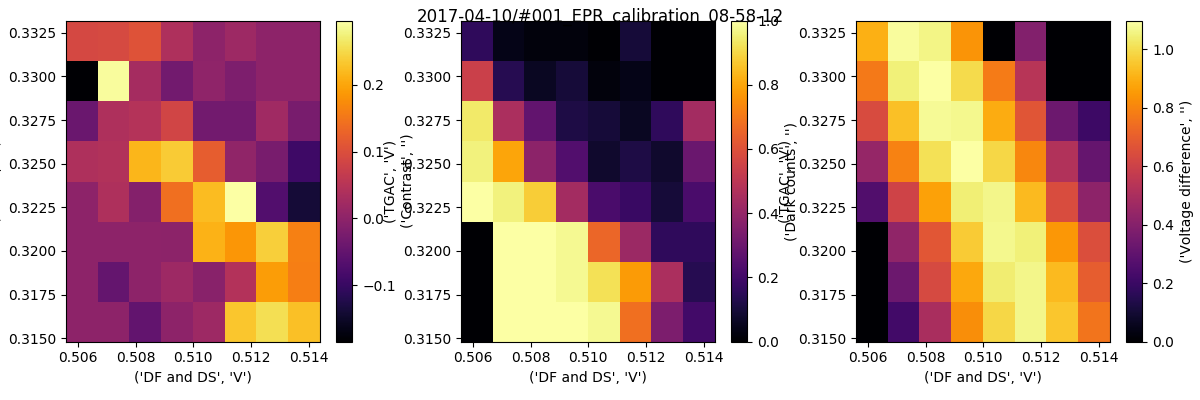

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-10/#001_EPR_calibration_08-58-12'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (8,)
   Setpoint | DF_DS_set          | DF_DS              | (8, 8)
   Measured | contrast           | contrast           | (8, 8)
   Measured | dark_counts        | dark_counts        | (8, 8)
   Measured | voltage_difference | voltage_difference | (8, 8)
   Measured | fidelity_empty     | fidelity_empty     | (8, 8)
   Measured | fidelity_load      | fidelity_load      | (8, 8)
started at 2017-04-10 09:07:08


In [46]:
EPR_parameter.settings(samples=50)
EPR_parameter.setup()
loop = Loop(
    y_sweep).loop(
        x_sweep).each(
            EPR_parameter).then(
                qc.Task(layout.stop))
data =  loop.get_data_set(name='EPR_calibration')

plot = qc.MatPlot(data.contrast, figsize=(12, 4), subplots=(1, 3))
plot.add(data.dark_counts, subplot=1)
plot.add(data.voltage_difference, subplot=2)
plt.tight_layout()

_ = loop.with_bg_task(plot.update).run()

layout.stop()

In [47]:
TGAC(0.3158) 
DF_DS(0.5139) 

## EPR - Single point

In [101]:
EPR_parameter.single_settings(samples=50, silent=False)
EPR_parameter();

contrast: 0.224
dark_counts: 0.220
voltage_difference: 0.674
fidelity_empty: 0.959
fidelity_load: 0.688


# Adiabatic sweep measurements

## ESR Adiabatic - Center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

To find the ESR frequency, use 28GHz * B0 as starting point, and search around that frequency.
Use a big initial frequency_deviation (around 60 MHz) and long duration (0.5 ms)
Once you see a spike in contrast, center around there and decrease both deviation and duration.

In [147]:
adiabatic_ESR_parameter.pulse_sequence['adiabatic']

FrequencyRampPulse(adiabatic (ESR), f_center=27976.10 MHz, f_dev=1.00, power=0, t_start=3, t_stop=3.3)

In [159]:
adiabatic_ESR_parameter.pulse_sequence['adiabatic'].duration=0.3#0.15
adiabatic_ESR_parameter.pulse_sequence['adiabatic'].frequency_deviation = 1e6#1e6
adiabatic_ESR_parameter.pulse_sequence['adiabatic']
adiabatic_ESR_freq_parameter = general_parameters.AttributeParameter(adiabatic_ESR_parameter.pulse_sequence['adiabatic'], 'frequency')


In [153]:
f_center = properties_config['frequency_ESR']
f_span = 5e6
f_step = 0.1e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(adiabatic_sweep_vals)))

Sweep vals: 50


<IPython.core.display.Javascript object>


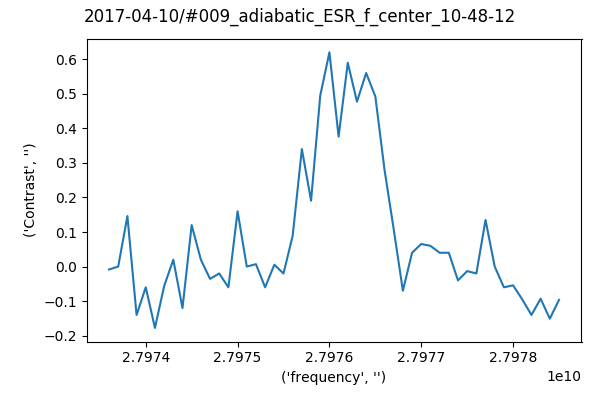

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-10/#009_adiabatic_ESR_f_center_10-48-12'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | frequency_set      | frequency          | (50,)
   Measured | contrast           | contrast           | (50,)
   Measured | dark_counts        | dark_counts        | (50,)
   Measured | voltage_difference | voltage_difference | (50,)
started at 2017-04-10 10:54:51


In [154]:
adiabatic_ESR_parameter.samples=50
loop = Loop(
    adiabatic_ESR_freq_parameter[adiabatic_sweep_vals]).each(
        adiabatic_ESR_parameter).then(
            qc.Task(layout.stop))
data = loop.get_data_set(name='adiabatic_ESR_f_center')

plot = qc.MatPlot(data.contrast)

_ = loop.with_bg_task(plot.update).run()

layout.stop()

In [158]:
properties_config['frequency_ESR'] = 27.9762e9
properties_config['frequencies_ESR']['down'] =  properties_config['frequency_ESR']

In [151]:
layout.stop()

## NMR adiabatic frequency scan

In [ ]:
#NMR sweep frequencies
f_center = 66.82e6
f_span = 3e6
f_step = 20e3
NMR_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(NMR_vals)))

In [ ]:
data = qc.Loop(adiabatic_NMR_parameter[NMR_vals]
              ).each(qc.Task(adiabatic_NMR_parameter.setup),
                     adiabatic_NMR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['up'])),
                     adiabatic_ESR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['down'])),
                     adiabatic_ESR_parameter,
                    ).run(name='NMR_adiabatic_sweep', progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_3_4)
plot.add(data.contrast_5_4)

## Adiabatic - frequency deviation versus ESR duration

This is a 2D scan of frequency deviation versus duration.
From this measurement, the minimum acceptable values for frequency deviation and ESR duration can be extracted.

In [44]:
pulse = adiabatic_ESR_parameter.pulse_sequence['adiabatic']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.arange(0.5e6, 2.1e6, 0.25e6))
adiabatic_duration_vals = list(np.arange(0.075, 0.251, 0.025))

In [50]:
adiabatic_ESR_parameter.samples = 400
data = qc.Loop(
    adiabatic_deviation_parameter[adiabatic_deviation_vals]).loop(
    adiabatic_duration_parameter[adiabatic_duration_vals]).each(
    qc.Task(partial(print_attr, adiabatic_ESR_parameter, 'pulse_sequence')),
    adiabatic_ESR_parameter).run(
    name='adiabatic_deviation_vs_duration', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-24/#034_adiabatic_deviation_vs_duration_17-17-26'
   <Type>   | <array_id>              | <array.name>        | <array.shape>
   Setpoint | frequency_deviation_set | frequency_deviation | (7,)
   Setpoint | duration_set            | duration            | (7, 8)
   Measured | contrast                | contrast            | (7, 8)
   Measured | dark_counts             | dark_counts         | (7, 8)
   Measured | voltage_difference      | voltage_difference  | (7, 8)
started at 2016-12-24 17:17:28


In [51]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Adiabatic - 2D scan (works)

In [160]:
adiabatic_ESR_parameter.pulse_sequence['adiabatic'].frequency =  properties_config['frequencies_ESR']['down']

In [298]:
adiabatic_ESR_parameter.pulse_sequence['plunge'].amplitude =0.1

In [299]:
#TGAC(0.3382) #factor 5
#DF_DS(0.5035) #factor 4 to matlab
y_sweep, x_sweep = create_set_vals(2, step_percentage=15, points=6)

<IPython.core.display.Javascript object>


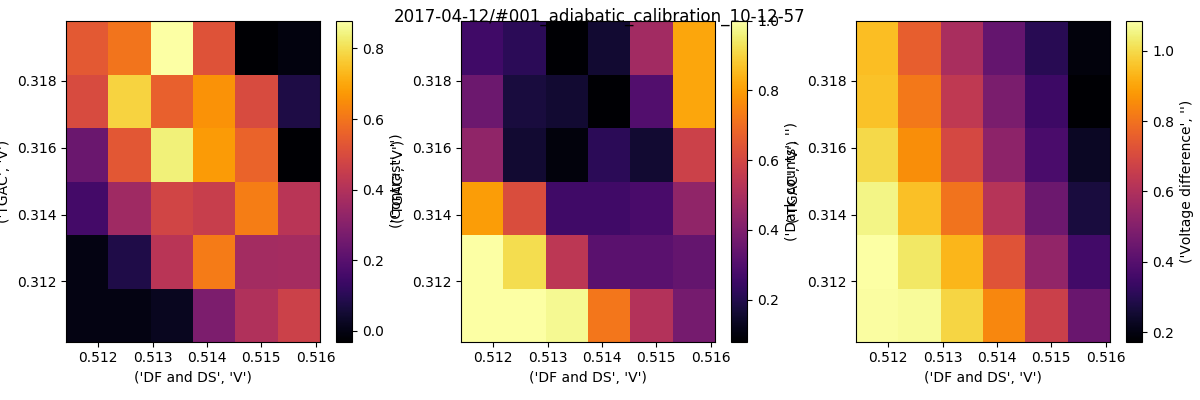

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-12/#001_adiabatic_calibration_10-12-57'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (6,)
   Setpoint | DF_DS_set          | DF_DS              | (6, 6)
   Measured | contrast           | contrast           | (6, 6)
   Measured | dark_counts        | dark_counts        | (6, 6)
   Measured | voltage_difference | voltage_difference | (6, 6)
started at 2017-04-12 10:17:51


In [300]:
adiabatic_ESR_parameter.settings(samples=50)
adiabatic_ESR_parameter.setup()
loop = Loop(
    y_sweep).loop(
        x_sweep).each(
            adiabatic_ESR_parameter).then(
                qc.Task(layout.stop))
data = loop.get_data_set(name='adiabatic_calibration')

plot = qc.MatPlot(data.contrast, figsize=(12, 4), subplots=(1, 3))
plot.add(data.dark_counts, subplot=1)
plot.add(data.voltage_difference, subplot=2)
plt.tight_layout()

_ = loop.with_bg_task(plot.update).run()

layout.stop()

In [301]:
TGAC(0.3190) 
DF_DS(0.5134) 

In [302]:
adiabatic_ESR_parameter()

[0.89959183673469389, 0.080000000000000002, 0.63950772390235588]

<IPython.core.display.Javascript object>


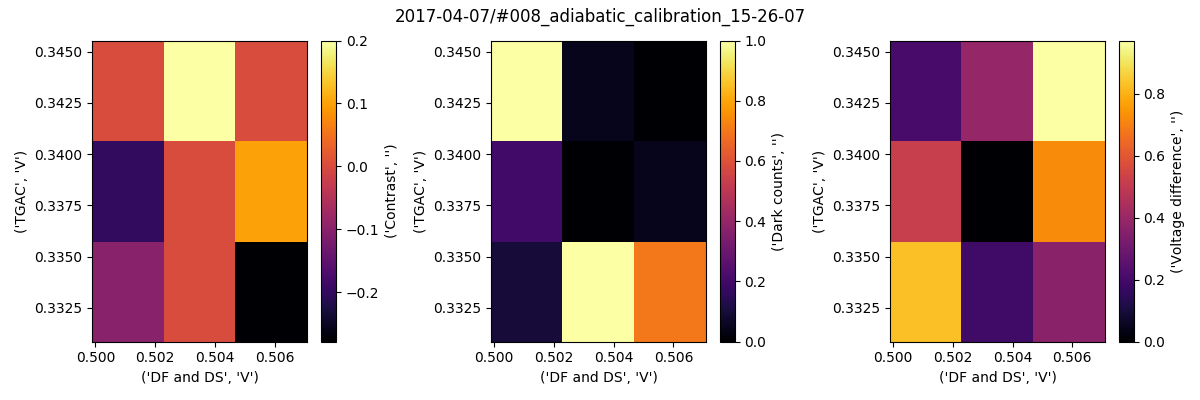

In [18]:
CalibrationPlot(data)

In [20]:
adiabatic_ESR_parameter.settings(samples=20)
adiabatic_ESR_parameter.setup()
loop = Loop(
    dummy_parameter[0:40:1]).each(
        qc.Task(DF_DS, 0.47677),
        qc.Task(TGAC, 0.41777),
        adiabatic_ESR_parameter,
        Loop(
        y_sweep).loop(
            x_sweep).each(
                adiabatic_ESR_parameter),
        qc.Task(sleep, 600)).then(
            qc.Task(layout.stop))
data = loop.get_data_set(name='continuos_adiabatic_calibration')

plot = qc.MatPlot(data.contrast_2_0, figsize=(12, 4), subplots=(1, 3))

_ = loop.with_bg_task(plot.update).run()

layout.stop()

<IPython.core.display.Javascript object>

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-07/#009_continuos_adiabatic_calibration_15-29-50'
   <Type>   | <array_id>                 | <array.name>       | <array.shape>
   Setpoint | dummy_set                  | dummy              | (40,)
   Measured | contrast_2_0               | contrast           | (40,)
   Measured | dark_counts_2_1            | dark_counts        | (40,)
   Measured | voltage_difference_2_2     | voltage_difference | (40,)
   Setpoint | TGAC_set                   | TGAC               | (40, 3)
   Setpoint | DF_DS_set                  | DF_DS              | (40, 3, 3)
   Measured | contrast_3_0_0_0           | contrast           | (40, 3, 3)
   Measured | dark_counts_3_0_0_1        | dark_counts        | (40, 3, 3)
   Measured | voltage_difference_3_0_0_2 | voltage_difference | (40, 3, 3)
started at 2017-04-07 15:30:34


KeyboardInterrupt: 

## Adiabatic - 2D deviation versus duration

In [ ]:
pulse = adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')


adiabatic_ESR_parameter.setup(samples=250, readout_threshold_voltage=readout_threshold_voltage,
                                save_traces=False)
data = qc.Loop(dummy_parameter[0:100:1]
              ).each(qc.Task(adiabatic_deviation_parameter, 5e6),
                     qc.Task(adiabatic_duration_parameter, .15),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                     qc.Task(adiabatic_deviation_parameter, 15e6),
                     qc.Task(adiabatic_duration_parameter, .35),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                    ).run(name='adiabatic_calibration',
                          progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_3_4);
plot.add(data.contrast_7_4)

## Flip nucleus

In [ ]:
# Try to flip the nucleus
adiabatic_NMR_parameter(frequency_center_NMR)
adiabatic_NMR_parameter.samples = 1
adiabatic_NMR_parameter();

## Find ESR frequency

In [ ]:
select_ESR_parameter.setup(samples=50, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(dummy_parameter[0:100:1]).each(qc.Task(adiabatic_NMR_parameter.setup),
                                             adiabatic_NMR_parameter,
                                             qc.Task(select_ESR_parameter.setup),
                                             select_ESR_parameter,
                                             qc.Task(adiabatic_ESR_parameter, partial(getattr, select_ESR_parameter, 'frequency_ESR')),
                                             qc.Task(adiabatic_deviation_parameter, 5e6),
                                             qc.Task(adiabatic_duration_parameter, .15),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                             qc.Task(adiabatic_deviation_parameter, 15e6),
                                             qc.Task(adiabatic_duration_parameter, .35),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                            ).run(name='test_find_ESR',
                                                 progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_up, label='nucleus up')
plot.add(data.contrast_down, label='nucleus down')
plot.add(data.contrast_8_4, label='ESR narrow')
plot.add(data.contrast_12_4, label='ESR wide')

# Rabis

## Find Rabi frequency

In [27]:
#determine Rabi frequency
rabi_ESR_parameter.pulse_sequence['rabi'].duration=0.1
rabi_ESR_parameter.pulse_sequence['rabi'].power=0
rabi_ESR_parameter.pulse_sequence['rabi'].t_start=3

f_center = 27.950885000e9 #properties_config['frequency_ESR']
rabi_ESR_parameter.pulse_sequence['rabi'].frequency = f_center
f_span = 5e6
f_step = 0.01e6
rabi_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(rabi_sweep_vals)))
rabi_ESR_parameter.pulse_sequence

Sweep vals: 500


PulseSequence with 5 pulses, duration: 27
	DCPulse(plunge, A=2, t_start=0, t_stop=5)
	SinePulse(rabi (ESR), f=27950.88 MHz, power=0, t_start=3, t_stop=3.1)
	DCPulse(read, A=0, t_start=5, t_stop=25)
	DCPulse(final, A=0, t_start=25, t_stop=27)
	
	Disabled pulses:
	SteeredInitialization(steered_initialization, t_no_blip=120 ms, t_max_wait=400, t_buffer=30, V_th=0.3333333333333333)

In [28]:
rabi_ESR_parameter.samples=50
data = qc.Loop(
    rabi_ESR_parameter[rabi_sweep_vals]).each(
    rabi_ESR_parameter).run(
    name='rabi_ESR_f_center', progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

DataSet:
data = qc.load_data('2017-01-13/#019_rabi_ESR_f_center_22-58-19')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | rabi_ESR_set       | rabi_ESR           | (500,)
   Measured | contrast           | contrast           | (500,)
   Measured | dark_counts        | dark_counts        | (500,)
   Measured | voltage_difference | voltage_difference | (500,)
started at 2017-01-13 22:58:23


In [28]:
max_val = data.contrast.argmax()
rabi_sweep_vals[max_val]

27950885000.0

In [16]:
rabi_frequency = 27950885000.0

## Rabi drive

In [19]:
rabi_drive_ESR_parameter.pulse_sequence['rabi'].duration=0.1
rabi_drive_ESR_parameter.pulse_sequence['rabi'].power=0
rabi_drive_ESR_parameter.pulse_sequence['rabi'].t_start=3

f_center = rabi_frequency #properties_config['frequency_ESR']
rabi_drive_ESR_parameter.pulse_sequence['rabi'].frequency = f_center
drive_duration_start = 0
drive_duration_stop = 0.1
drive_duration_step = 0.0005
drive_duration_sweep_vals = list(np.arange(drive_duration_start, drive_duration_stop, drive_duration_step))
print('Sweep vals: {}'.format(len(drive_duration_sweep_vals)))
rabi_drive_ESR_parameter.pulse_sequence

Sweep vals: 200


PulseSequence with 5 pulses, duration: 27
	DCPulse(plunge, A=2, t_start=0, t_stop=5)
	SinePulse(rabi (ESR), f=27950.88 MHz, power=0, t_start=3, t_stop=3.1)
	DCPulse(read, A=0, t_start=5, t_stop=25)
	DCPulse(final, A=0, t_start=25, t_stop=27)
	
	Disabled pulses:
	SteeredInitialization(steered_initialization, t_no_blip=120 ms, t_max_wait=400, t_buffer=30, V_th=0.3333333333333333)

In [31]:
rabi_drive_ESR_parameter.samples=80
data = qc.Loop(
    rabi_drive_ESR_parameter[drive_duration_sweep_vals]).each(
    rabi_drive_ESR_parameter).run(
    name='rabi_drive_ESR', progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

DataSet:
data = qc.load_data('2017-01-13/#005_rabi_drive_ESR_13-07-36')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | rabi_drive_ESR_set | rabi_drive_ESR     | (100,)
   Measured | contrast           | contrast           | (100,)
   Measured | dark_counts        | dark_counts        | (100,)
   Measured | voltage_difference | voltage_difference | (100,)
started at 2017-01-13 13:07:39


In [36]:
max_val = data.contrast.argmax()
pulse_length = drive_duration_sweep_vals[max_val]
pi_pulse_length =0.007
pulse_length/2


0.010999999999999999

# Dark counts (works)

In [167]:
dark_counts_parameter.single_settings(samples=50, silent=False)
dark_counts_parameter();

dark_counts: 0.102


## Dark counts vs plunge voltage

In [13]:
dark_counts_plunge_parameter.samples=50
adiabatic_ESR_parameter.samples=50

T1_parameter(10)
data = qc.Loop(
    dummy_parameter[0:20:1]).loop(
        plunge_voltage_parameter[1:2.5:0.1]).each(
            dark_counts_plunge_parameter,
            adiabatic_ESR_parameter).run(
    name='T1_plunge_voltage', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-29/#026_T1_plunge_voltage_15-36-23'
   <Type>   | <array_id>           | <array.name>       | <array.shape>
   Setpoint | dummy_set            | dummy              | (20,)
   Setpoint | plunge_amplitude_set | plunge_amplitude   | (20, 15)
   Measured | up_proportion        | up_proportion      | (20, 15)
   Measured | num_traces           | num_traces         | (20, 15)
   Measured | contrast             | contrast           | (20, 15)
   Measured | dark_counts          | dark_counts        | (20, 15)
   Measured | voltage_difference   | voltage_difference | (20, 15)
started at 2016-12-29 15:36:25


In [22]:
plot = qc.MatPlot(subplots=(1,3), figsize=(12,4))
plot.add(data.up_proportion, subplot=0)
plot.add(data.contrast, subplot=1)
plot.add(np.nanmean(data.contrast, 0), x=data.plunge_amplitude_set[0], subplot=2, label='contrast')
plot.add(np.nanmean(data.up_proportion, 0), x=data.plunge_amplitude_set[0], subplot=2, label='dark counts')
plot[2].set_xlabel('plunge_amplitude')
plot[2].legend()
plot.tight_layout()

# Read level sweep (to be fixed)

In [ ]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

In [ ]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

## T1 - Single point

In [7]:
T1_parameter(20)
T1_parameter.single_settings(samples=50)
T1_parameter.setup()
%time up_proportion, num_traces = T1_parameter()

NotImplementedError: no set cmd found in Parameter T1_acquisition_ESR

In [ ]:
plot_traces(T1_parameter.trace_segments['output']['read'])

## T1 - single scan

In [185]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 3.8, num=10, base=10))

# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [10.0, 20.469682718075209, 41.900791057866691, 85.769589859089407, 175.56762912750014, 359.38136638046257, 735.64225445964132, 1505.8363542798415, 3082.3992397451434, 6309.5734448019302]


In [179]:
T1_parameter.pulse_sequence['steered_initialization'].enabled = True

In [180]:
T1_parameter.pulse_sequence

PulseSequence with 5 pulses, duration: 1022.0
	SteeredInitialization(steered_initialization, t_no_blip=120 ms, t_max_wait=400, t_buffer=30, V_th=0.3333333333333333)
	DCPulse(plunge, A=0.08, t_start=0, t_stop=1000.0)
	FrequencyRampPulse(adiabatic (ESR), f_center=27976.20 MHz, f_dev=0.50, power=0, t_start=3, t_stop=3.2)
	DCPulse(read, A=0, t_start=1000.0, t_stop=1020.0)
	DCPulse(final, A=0, t_start=1020.0, t_stop=1022.0)

<IPython.core.display.Javascript object>


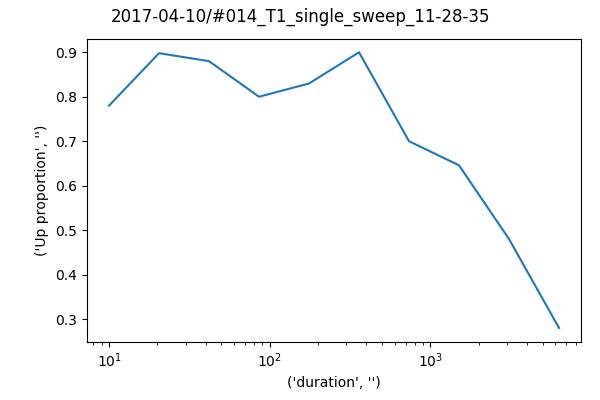

C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2899: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-10/#014_T1_single_sweep_11-28-35'
   <Type>   | <array_id>    | <array.name>  | <array.shape>
   Setpoint | duration_set  | duration      | (10,)
   Measured | up_proportion | up_proportion | (10,)
   Measured | num_traces    | num_traces    | (10,)
started at 2017-04-10 11:41:28


In [186]:
# Single T1 sweep
T1_parameter.settings(samples=50)
T1_parameter.setup()
T1_duration_parameter = general_parameters.AttributeParameter(T1_parameter.pulse_sequence['plunge'], 'duration')

loop = Loop(
    T1_duration_parameter[T1_wait_times]).each(
    T1_parameter).then(
        qc.Task(layout.stop))
data = loop.get_data_set(name='T1_single_sweep')

plot = qc.MatPlot(data.up_proportion)
plot[0].set_xscale('log')
    
_ = loop.with_bg_task(plot.update).run()

layout.stop()

## T1 - single free/uncompensated scan

In [14]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 2, num=5, base=10))
# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))
# Single T1 sweep
T1_parameter = acquisition_parameters.T1Parameter(mode='ESR')
T1_parameter.samples=50


Shuffled T1 wait times: [10.0, 17.782794100389228, 31.622776601683793, 56.234132519034908, 100.0]


In [128]:
#T1_parameter.pulse_sequence['plunge'].amplitude #= (0.1,0.2)
#T1_parameter.pulse_sequence
T1_parameter.pulse_sequence['steered_initialization'].enabled = False
T1_parameter.pulse_sequence

PulseSequence with 5 pulses, duration: 27
	DCPulse(plunge, A=(0.08, 0.042666666666666665), t_start=0, t_stop=5)
	FrequencyRampPulse(adiabatic (ESR), f_center=27951.00 MHz, f_dev=0.50, power=0, t_start=3, t_stop=3.2)
	DCPulse(read, A=0, t_start=5, t_stop=25)
	DCPulse(final, A=0, t_start=25, t_stop=27)
	
	Disabled pulses:
	SteeredInitialization(steered_initialization, t_no_blip=120 ms, t_max_wait=400, t_buffer=30, V_th=0.3333333333333333)

In [124]:
#layout.target_pulse_sequence(T1_parameter.pulse_sequence)
#arbstudio_interface.pulse_sequence()

In [129]:
T1_wait_times = list(np.logspace(1, 3, num=5, base=10))
T1_parameter.samples=30
data = qc.Loop(
    T1_parameter[T1_wait_times]).each(
    T1_parameter).run(name='T1_single_sweep')

plot = qc.MatPlot()
plot.add(data.up_proportion)
plot[0].set_xscale('log')

DataSet:
data = qc.load_data('2017-01-24/#020_T1_single_sweep_17-10-21')
   mode = DataMode.PULL_FROM_SERVER
   <Type>   | <array_id>           | <array.name>     | <array.shape>
   Setpoint | T1_wait_time_ESR_set | T1_wait_time_ESR | (5,)
   Measured | up_proportion        | up_proportion    | (5,)
   Measured | num_traces           | num_traces       | (5,)
started at 2017-01-24 17:10:25


C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2899: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


## T1 - Multiple scans

In [90]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1, 4.2, num=12, base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [19.539304046896113, 4151.2780027522995, 74.598015234879369, 38.178440263705077, 15848.931924611141, 10.0, 1087.3356727196567, 145.75933009692972, 8111.3083078968812, 284.80358684358049, 556.48638769832951, 2124.5782310305694]


In [93]:
T1_parameter.samples = 50
dark_counts_parameter.samples = 100
adiabatic_ESR_parameter.samples = 100
data = qc.Loop(
    dummy_parameter[0:80:1]).each(
    adiabatic_ESR_parameter,
    dark_counts_parameter,
    qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter),
                    ).run(name='T1_data', progress_interval=True)

DataSet:
   mode = DataMode.PULL_FROM_SERVER
   data = qc.load_data('2016-12-30/#053_T1_data_23-04-20')
   <Type>   | <array_id>           | <array.name>       | <array.shape>
   Setpoint | dummy_set            | dummy              | (80,)
   Measured | contrast             | contrast           | (80,)
   Measured | dark_counts_0_1      | dark_counts        | (80,)
   Measured | voltage_difference   | voltage_difference | (80,)
   Measured | dark_counts_1        | dark_counts        | (80,)
   Setpoint | T1_wait_time_ESR_set | T1_wait_time_ESR   | (80, 12)
   Measured | up_proportion        | up_proportion      | (80, 12)
   Measured | num_traces           | num_traces         | (80, 12)
started at 2016-12-30 23:04:25


In [99]:
plot = qc.MatPlot(subplots=(1,3), figsize=(12,3.5))
plot.add(data.up_proportion, subplot=0)
# plot.subplots[0].set_xscale('log')
# plot.add(data.T1_wait_time_set[0], np.nanmean(data.up_proportion_5_0_0, axis=0), subplot=2)
# plot.subplots[1].set_xscale('log')
# plot.subplots[1].set_xlim(10, 13000)
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts_1, subplot=2)
# plot.add(data.dark_counts_0_1, subplot=3)
plt.tight_layout()

## T1 - Plunge voltage scan
This scan measures the contrast for a fixed wait time as the plunge voltage is varied

### Fixed-tau plunge voltage scan

In [90]:
T1_parameter.samples=50

T1_parameter(2500)
data = Loop(
    dummy_parameter[0:10:1]).each(
        adiabatic_ESR_parameter,
        Loop(plunge_voltage_parameter[1:2.6:0.25]).each(
            T1_parameter)).run(
    name='T1_plunge_voltage', progress_interval=True)

DataSet:
   mode = DataMode.PULL_FROM_SERVER
   data = qc.load_data('2016-12-30/#026_T1_plunge_voltage_17-01-15')
   <Type>   | <array_id>           | <array.name>       | <array.shape>
   Setpoint | dummy_set            | dummy              | (10,)
   Measured | contrast             | contrast           | (10,)
   Measured | dark_counts          | dark_counts        | (10,)
   Measured | voltage_difference   | voltage_difference | (10,)
   Setpoint | plunge_amplitude_set | plunge_amplitude   | (10, 7)
   Measured | up_proportion        | up_proportion      | (10, 7)
   Measured | num_traces           | num_traces         | (10, 7)
started at 2016-12-30 17:01:19


In [91]:
plot = qc.MatPlot(subplots=3)
plot.add(data.up_proportion, subplot=0)
plot.add(np.nanmean(data.up_proportion, 0), x=data.plunge_amplitude_set[0], subplot=1)
plot[1].set_xlabel('amplitude')
plot.add(data.contrast, subplot=2, label='contrast')
plot.add(data.dark_counts, subplot=2, label='dark counts')
plot[2].legend()

C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


### Detailed plunge voltage scan

In [262]:
# Calculate T1 durations
#T1_wait_times = list(np.logspace(1, 2, num=5, base=10))
T1_wait_times = list(np.logspace(1, 4.05, num=12, base=10))

print('T1 wait times: {}'.format(T1_wait_times))

T1 wait times: [10.0, 18.935323415445275, 35.85464728475101, 67.891934228347694, 128.55557319139032, 243.4241355236922, 460.9314733266288, 872.78865197974039, 1652.6535398566896, 3129.3529270866898, 5925.530975545681, 11220.18454301963]


In [263]:
T1_parameter.samples = 25
dark_counts_parameter.samples = 100
adiabatic_ESR_parameter.samples = 100

T1_duration_parameter = general_parameters.AttributeParameter(T1_parameter.pulse_sequence['plunge'], 'duration')

<IPython.core.display.Javascript object>


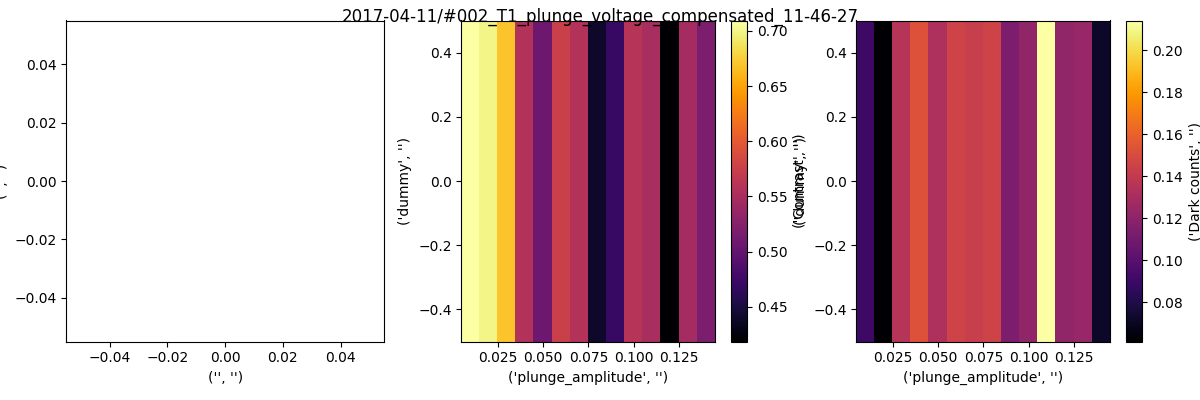

C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-11/#002_T1_plunge_voltage_compensated_11-46-27'
   <Type>   | <array_id>           | <array.name>       | <array.shape>
   Setpoint | dummy_set            | dummy              | (30,)
   Setpoint | plunge_amplitude_set | plunge_amplitude   | (30, 14)
   Measured | dark_counts_0_0      | dark_counts        | (30, 14)
   Measured | contrast             | contrast           | (30, 14)
   Measured | dark_counts_1_1      | dark_counts        | (30, 14)
   Measured | voltage_difference   | voltage_difference | (30, 14)
   Setpoint | duration_set         | duration           | (30, 14, 12)
   Measured | up_proportion        | up_proportion      | (30, 14, 12)
   Measured | num_traces           | num_traces         | (30, 14, 12)
started at 2017-04-11 17:30:36


KeyboardInterrupt: 

In [257]:
loop = Loop(
    dummy_parameter[0:30:1]).loop(
        plunge_voltage_parameter[0.01:0.15:0.01]).each(
            dark_counts_parameter,
            adiabatic_ESR_parameter,
            Loop(T1_duration_parameter[T1_wait_times]).each(
                T1_parameter)).then(
                qc.Task(layout.stop))
data = loop.get_data_set(name='T1_plunge_voltage_compensated')

plot = qc.MatPlot(subplots=(1,3), figsize=(12,4))
plot.add(T1_wait_times,data.plunge_amplitude_set[0], np.nanmean(data.up_proportion, 0),subplot=0)
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts_0_0, subplot=2)
plt.tight_layout()

_ = loop.with_bg_task(plot.update).run()

layout.stop()

## Free/Uncompensated plunge sweep T1

In [303]:
free_plunge_voltage_parameter = general_parameters.AttributeParameter(T1_parameter.pulse_sequence['plunge'], 'amplitude', scale = [8/15, 1])
free_plunge_voltage_parameter(0.12)
T1_parameter.pulse_sequence['plunge'].amplitude 

(0.225, 0.12)

TGAC (25) / DF (20)

In [272]:
layout.stop()

<IPython.core.display.Javascript object>


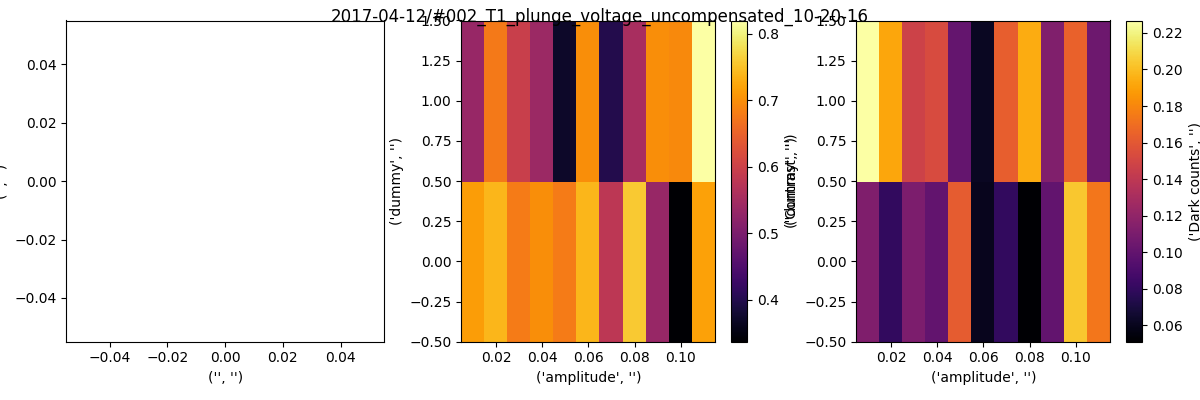

C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [ ]:
loop = Loop(
    dummy_parameter[0:30:1]).loop(
        free_plunge_voltage_parameter[0.01:0.12:0.01]).each(
            dark_counts_parameter,
            adiabatic_ESR_parameter,
            Loop(T1_duration_parameter[T1_wait_times]).each(
                T1_parameter)).then(
                qc.Task(layout.stop))
data = loop.get_data_set(name='T1_plunge_voltage_uncompensated')

plot = qc.MatPlot(subplots=(1,3), figsize=(12,4))
plot.add(T1_wait_times,data.amplitude_set[0], np.nanmean(data.up_proportion, 0),subplot=0)
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts_0_0, subplot=2)
plt.tight_layout()

_ = loop.with_bg_task(plot.update).run()

layout.stop()

# Notes

## Acquisition parameters

Acquisition parameters are used to perform simple measurements containing a single pulse sequence.
Examples are DCParameter, AdiabaticSweepParameter, DarkCountsParameter, etc.

Acquisition parameters are run by performing by calling the parameter (parameter(), which performs a parameter.get() command).
At the start of a get(), the pulse sequence is sent to the Layout, which sets up all the instruments.
The exception to this is the DC parameter, which needs a separate setup at the start of a measurement.

## Config settings

In many cases, settings for parameters and pulses are setup-specific.
To keep the SilQ software general, these settings have been moved to the QCoDeS config.
The config is imported as 

`from qcodes import config`

The config is saved to a file, and has several save locations. We usually used the current working directory (cwd) for saving/loading.
For more info see config in qcodes/docs/examples.

Special care must be taken when combining the config with multiprocessing.
When a new process is started, it will load the config from the physical file.
When changing settings in the config, it is therefore necessary to perform a config.save_to_cwd() if you want the changes to be reflected in any multiprocessing measurements.

Several objects (including AcquisitionParameters and pulses) are subclasses of SettingsClass.
The SettingsClass overrides `__getattribute__`, which means that when requesting an attribute (obj.attr), the following steps are undertaken.
1. If attr is a key in either `obj._single_settings`, or `obj._temporary_settings`, return that value (see below for more information).
2. If obj.attr does not exist, raise an AttributeError as usual.
3. If the attribute exists and is not equal to None, return that value.
4. If the attribute exists but is equal to None, search for its value in the respective config*:
    1. If obj.mode is not None and 1{attr}_{mode}1 is a key in the config, return value
    2. If attr is key in the config, return that value
    
By default, the respective config is `config['user']['properties']`. 
However, for pulses, the respective config is `config['user']['pulses'][{pulse_name}]`

Attributes can be temporarily overriden through `obj.single_settings(attr1=val1, ...)` and `obj.temporary_settings(attr1=val1, ...)`.
Single settings are always cleared after an obj.get() command, and so are useful when you for instance want to do a single measurement with different settings than usual. Temporary settings are in effect until you perform an obj.clear_settings() command.

To enable/disable steered initialization, use:

adiabatic_sweep_parameter.steered_intialization = True/False

This adds/removes the steered initialization "pulse" from the EPR_parameter.pulse_sequence
If steered_initialization is enabled, you can access and modify its properties via

steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

Note that steered initialization is currently only implemented for the adiabatic sweep, but is easy to add for other parameters, such as T1_parameter (just add the pulse)

steered_controller is the acquisition controller specifically for steered initialization
You can look at the initialization traces when using steered initialization.

First set the flag 
steered_controller.record_initialization_traces(True)

The initialization traces can then be accessed
steered_controller.initialization_traces()

You can also look at the first buffer after the pulseblaster.start() command has been set via
steered_controller.post_initialization_traces()
This can be useful for checking the delay between sending the command and plunging

To setup a parameter where steered initialization is enabled, you must pass it a readout threshold voltage every time.

adiabatic_sweep_parameter.setup(readout_threshold_voltage=threshold_voltage)

This threshold voltage can be obtained from an EPR scan (see T1_measurement):

EPR_parameter.setup(samples=30)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)

In [ ]:
adiabatic_sweep_parameter.pulse_sequence.add(adiabatic_sweep_parameter._steered_initialization)
adiabatic_sweep_parameter.pulse_sequence.remove(adiabatic_sweep_parameter._steered_initialization)

To save raw traces, use:

EPR_parameter.setup(save_traces=True, data_manager=data_manager_raw)

In [ ]:
plot = CalibrationPlot(data)

# Measurements run from Slack